# SuperTrend Meo

## Import modules

In [1]:
#!pip install yfinance
#!pip install pandas_ta
#!pip install python-binance
try:
  import pandas_ta
except ModuleNotFoundError:
  !pip install pandas_ta
  pass

try:
  import binance
except ModuleNotFoundError:
  !pip install python-binance
  pass
#Notes
#https://medium.datadriveninvestor.com/the-supertrend-implementing-screening-backtesting-in-python-70e8f88f383d
#https://twopirllc.github.io/pandas-ta/#overlap-33

# Don't forget to activate

In [2]:
#basestuffs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#timestuffs
from datetime import datetime, timedelta
import time

#financestuffs
import pandas_ta as ta
import math
import configparser
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager

#query
import urllib.request
import json

## Parameters

In [3]:
# ############### PARAMETERS ############################## #
#crypto name
crypto ="BNB"

# TIMESPAN
atr_period = 10
atr_multiplier = 3
p = 6 # number of times atr should be added or removed from current price to obtain Target // StopLoss

# FREQ
#fr_bnb = '1h'
fr_bnb = '1m'
fr_ml = 'H'
lm= 20000
ln_tf = "15min" #lunarcrush timeframe

#lunarcashapi
api_key = '5npiw6btuqo9hgg5sut30c'

################ API Instantiation
# instantiate parser to load ini file
config = configparser.ConfigParser()
config.read('/content/drive/MyDrive/Colab Notebooks/CryptoBots/CryptoBot/credentials.ini') #Set to TESTNET

api_k = config['general']['api_k']
api_sk = config['general']['api_sk']

# TESTNET instantiate parser to load ini file
t_config = configparser.ConfigParser()
t_config.read('/content/drive/MyDrive/Colab Notebooks/CryptoBots/CryptoBot/testnet_credentials.ini') #Set to TESTNET 1, for TESTNET 2 'goku_testnet_credentials.ini' 

t_api_k = t_config['general']['api_k']
t_api_sk = t_config['general']['api_sk']

## Functions

In [4]:
def get_klines_iter(symbol, interval, limit=5000):
  
  df = pd.DataFrame()
  url = 'https://api.binance.com/api/v3/klines?symbol=' + \
          symbol + '&interval=' + interval + '&limit='  + str(limit)
  #print(url)

  df2 = pd.read_json(url)
  df2.columns = ['Opentime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Closetime', 'Quote asset volume', 'Number of trades','Taker by base', 'Taker buy quote', 'Ignore']
  df = pd.concat([df2, df], axis=0, ignore_index=True, keys=None)
       
  df.reset_index(drop=True, inplace=True)
  #convert to datetime // round closetime
  df.Opentime = pd.to_datetime(df.Opentime, unit='ms')
  df.Closetime = pd.to_datetime(df.Closetime, unit='ms') + timedelta(milliseconds=1) 
  # Rename closetime to date
  df.rename(columns={"Closetime":"date"}, inplace=True) 
  
  #set closetime to index
  df.index=df.date
  
  #short df to essentials
  df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

  return df 

In [5]:
def conditions(df, p=6):
  #add supatrend
  df['st_value'] = df.ta.supertrend(period=atr_period, multiplier=atr_multiplier)['SUPERT_7_3.0']
  df['st_ind'] = df.ta.supertrend(period=atr_period, multiplier=atr_multiplier)['SUPERTd_7_3.0']

  # EMA200, ATR and StochRSI
  df['ema200'] = df.ta.ema(length=200)
  df['atr'] = df.ta.atr()
  df['rsi_stoch_k'] = df.ta.stochrsi(length = 14, k=1)['STOCHRSIk_14_14_1_3']
  df['rsi_stoch_d'] = df.ta.stochrsi(length = 14, k=1)['STOCHRSId_14_14_1_3']
  df.dropna(inplace=True)

  # Some conditions
  #df['price_above_ema200'] = np.where(df.Close>df.ema200, 1, 0)
  #df['rsi_sig'] = np.where(df['rsi_stoch_k'] < 20, 1, 0) + np.where(df['rsi_stoch_k'] > 80, -1, 0) # <20 (oversold) value is 1, >80 value is 80 (overbought) # RSI-K used in the strat
  
  # rsi_sig_dif = 1 crossing downtrend 80 // crossing downtrend 20 (BUY SIG)
  # rsi_sig_dif = -1 crossing uptrend 80 (SELL SIG) // crossing uptrend 20
  #df['rsi_sig_diff'] = df['rsi_sig'].diff()
  df['Buy'] = np.where((df.Close > df.ema200) & (df['st_ind'] == 1) & (df['rsi_stoch_k'] < 20), 1, 0)

  #comment 
  #(df.Close - p * df.atr  >= df.Low.shift(-1)), 1, 0)
  # check if the trade would have worked // check if the lower price of next period is higher than our stoploss

  # Ratio 1:1
  df['Target'] = np.where(df['Buy'] == 1, df.Close + p * df.atr, 0) 
  df['Stop'] = np.where(df['Buy'] == 1, df.Close - p * df.atr, 0) 
 
  return df

In [6]:
def buys_sells_df(df):
  
  # Builds a Buy and Sell dataframe to check profitability
  ### Buy and Sell conditions
  buys, sells = [], []
  for i in range(len(df)):
    if df.Buy.iloc[i]:
      buys.append(df.iloc[i].name)
      
      for j in range(len(df) - i):
        if df.Target.iloc[i] < df.Close.iloc[i + j] or \
        df.Stop.iloc[i] > df.Close.iloc[i + j]:
          sells.append(df.iloc[i + j].name)
          break
  frame = pd.DataFrame([buys,sells]).T.dropna()
  frame.columns = ['Buys', 'Sells']
  return frame

In [7]:
def get_lunarcash(api_key, crypto, datapoints, ln_tf):
  ur = "https://api.lunarcrush.com/v2?data=assets&key=" + api_key + "&symbol=" + crypto + "&data_points="+ str(datapoints) +"&interval=" + ln_tf
  ass = json.loads(urllib.request.urlopen(ur).read())
  print(ur)
  #collect id and symbol // timeseries
  lab = pd.DataFrame(ass['data'])[['id', 'name','symbol']]
  ts = pd.DataFrame(ass['data'][0]['timeSeries'])
  #merge
  lncrush = pd.merge(lab, ts, how='right', left_on='id', right_on='asset_id')
  lncrush['time'] = pd.to_datetime(lncrush['time'], unit='s')

  lncrush = lncrush[['symbol', 'asset_id', 'time', 'open', 'close', 'high',
       'low', 'volume', 'market_cap', 'average_sentiment', 'price_score', 
       'social_impact_score','correlation_rank', 'galaxy_score', 'volatility', 
       'alt_rank']]
  lncrush.rename(columns={"time":"date"}, inplace=True)
  lncrush.index = lncrush.date

  return lncrush

In [8]:
def plot_supatrend_stoch(df, actualtrades):
  # SupaTrend & Plot
  
  st = df.ta.supertrend(period=atr_period, multiplier=atr_multiplier)
  strsi = pd.DataFrame({'STOCHRSIk_14_14_1_3' : df.ta.stochrsi(length = 14, k=1)['STOCHRSIk_14_14_1_3'], 'STOCHRSId_14_14_1_3' : df.ta.stochrsi(length = 14, k=1)['STOCHRSId_14_14_1_3'], "HI" : [80]*len(df.ta.stochrsi(length = 14, k=1).index), "LO" : [20]*len(df.ta.stochrsi(length = 14, k=1).index)})
  st["Close"] = df.Close
  st["ema200"] = df.ema200
  #print(st.columns)

  #figures

  fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(20,10))
  
  ax1.plot(st['SUPERTl_7_3.0'], color='green', label='SuperTrend LONG')
  ax1.plot(st['SUPERTs_7_3.0'], color='red', label='SuperTrend SHORT')
  ax1.plot(st['Close'], color='black', label='Price')
  ax1.plot(st[st.columns[-3:]]['ema200'], color='blue', label='ema200')
  ax1.set_title(crypto + " - " + fr_bnb)
  ax1.plot(actualtrades.Buys, df.loc[actualtrades.Buys]['Close'], '^', markersize=10, color='g')
  ax1.plot(actualtrades.Sells, df.loc[actualtrades.Sells]['Close'], '^', markersize=10, color='r')
  ax1.legend()

  ax2.plot(strsi['STOCHRSIk_14_14_1_3'], color ='red', label='stoch. RSI k')
  ax2.plot(strsi['STOCHRSId_14_14_1_3'], color='blue', label='stoch. RSI D')
  ax2.plot(strsi['HI'], color='black', linestyle="--")
  ax2.plot(strsi['LO'], color='black', linestyle="--")
  ax2.grid(True)
  ax2.legend()
  plt.show()
 

## Load data

In [9]:
df = get_klines_iter(crypto+'USDT',fr_bnb, limit=lm)

In [10]:
#data = get_lunarcash(api_key, crypto, lm, 'min')

## Conditions

Let's define buying and selling conditions as stated in https://www.youtube.com/watch?v=6zOMjMGM0ko&t=7s

LONG Conditions:


*   Price over ema200
*   Long signal on SuperTrend
*   Stock RSI under 20

SHORT Conditions:


*   Price under ema200
*   SHORT signal on SuperTrend
*   Stock RSI over 80

SIMPLE SPOT VERSION
* Market : CRYPTO
* Define Trend : stock above 200-day ema
* Entry : Stochastic RSI comes below 20
* Target Price : 6 * ATR Higher or Lower to the Entry Price


In [11]:
df = conditions(df)

## Backtest Trades and Profits

In [12]:
%load_ext google.colab.data_table
df

,Open,High,Low,Close,Volume,st_value,st_ind,ema200,atr,rsi_stoch_k,rsi_stoch_d,Buy,Target,Stop
date,,,,,,,,,,,,,,
2022-05-17 23:31:00,307.9,308.0,307.7,307.7,345.561,306.597462,1,304.186500,0.417802,58.771371,67.407378,0,0.000000,0.000000
2022-05-17 23:32:00,307.8,307.9,307.4,307.4,328.432,306.597462,1,304.218475,0.423674,31.928114,56.289579,0,0.000000,0.000000
2022-05-17 23:33:00,307.4,307.6,307.1,307.1,367.009,306.597462,1,304.247147,0.429126,7.873061,32.857515,1,309.674753,304.525247
2022-05-17 23:34:00,307.1,307.3,307.0,307.1,488.733,306.597462,1,304.275534,0.419902,0.000000,13.267058,1,309.619414,304.580586
2022-05-17 23:35:00,307.1,307.2,306.8,306.8,212.814,306.597462,1,304.300653,0.418481,0.000000,2.624354,1,309.310884,304.289116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-18 12:47:00,301.0,301.0,300.3,300.3,385.717,301.301355,-1,301.454596,0.416544,24.262797,45.254151,0,0.000000,0.000000
2022-05-18 12:48:00,300.4,300.5,300.0,300.3,455.242,301.301355,-1,301.443108,0.422505,24.262797,37.068448,0,0.000000,0.000000
2022-05-18 12:49:00,300.3,300.3,299.3,299.3,911.762,301.301355,-1,301.421783,0.463755,0.000000,16.175198,0,0.000000,0.000000


In [13]:
frame = buys_sells_df(df)
actualtrades = frame[frame.Buys > frame.Sells.shift(1)]
actualtrades = frame[:1].append(actualtrades)

In [14]:
actualtrades

,Buys,Sells
0,2022-05-17 23:33:00,2022-05-18 01:29:00
29,2022-05-18 03:03:00,2022-05-18 03:13:00
31,2022-05-18 09:12:00,2022-05-18 10:21:00


In [15]:
print(df.loc[actualtrades.Buys[0]])
print(df.loc[actualtrades.Sells[0]])

Open           307.400000
High           307.600000
Low            307.100000
Close          307.100000
Volume         367.009000
st_value       306.597462
st_ind           1.000000
ema200         304.247147
atr              0.429126
rsi_stoch_k      7.873061
rsi_stoch_d     32.857515
Buy              1.000000
Target         309.674753
Stop           304.525247
Name: 2022-05-17 23:33:00, dtype: float64
Open             305.400000
High             305.500000
Low              303.400000
Close            304.000000
Volume         16253.216000
st_value         306.392775
st_ind            -1.000000
ema200           305.858191
atr                0.491856
rsi_stoch_k        0.000000
rsi_stoch_d        0.000000
Buy                0.000000
Target             0.000000
Stop               0.000000
Name: 2022-05-18 01:29:00, dtype: float64


In [16]:
# Profits
profits = (df.loc[actualtrades.Sells].Close.values - \
           df.loc[actualtrades.Buys].Close.values) / df.loc[actualtrades.Buys].Close.values
win = len([i for i in profits if i> 0])
print('{} wins out of {} trades i.e. {} % winrate and a relative profit of {} % and a cumulative return of {} '.format(win, len(profits), 100 * win/len(profits), profits.mean() * 100, (profits + 1).cumprod()[-1]))

1 wins out of 3 trades i.e. 33.333333333333336 % winrate and a relative profit of -0.3227074824632363 % and a cumulative return of 0.9902600806384918 


In [17]:
profits

array([-0.01009443, -0.00721785,  0.00763106])

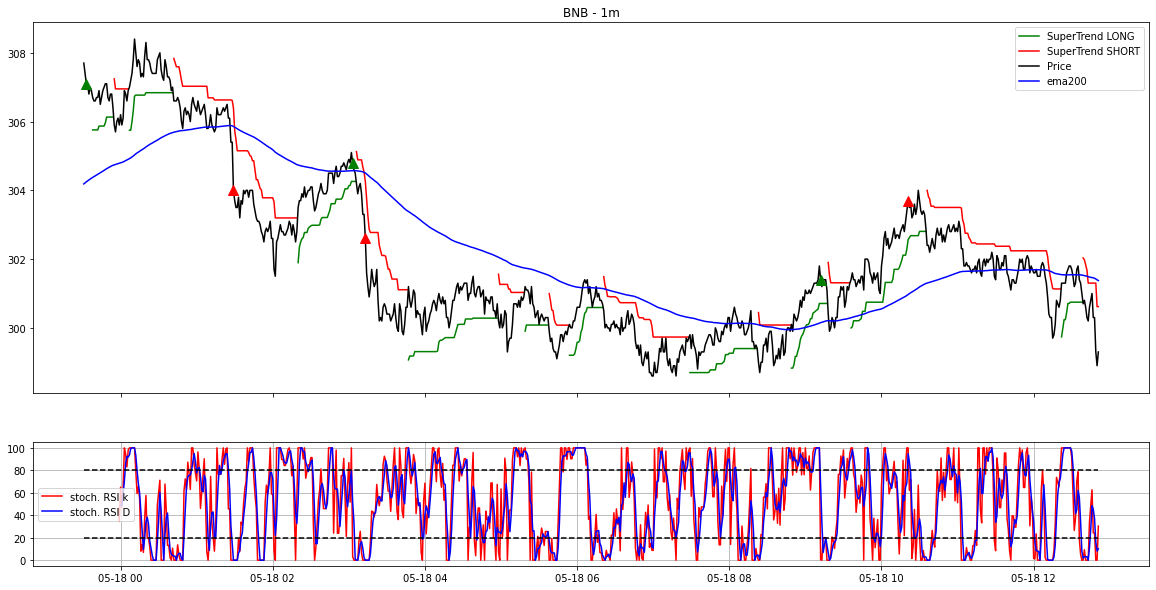

In [18]:
plot_supatrend_stoch(df, actualtrades)
#df.columns

In [19]:
df.tail(2)

,Open,High,Low,Close,Volume,st_value,st_ind,ema200,atr,rsi_stoch_k,rsi_stoch_d,Buy,Target,Stop
date,,,,,,,,,,,,,,
2022-05-18 12:50:00,299.3,299.3,298.5,298.9,1621.587,300.617025,-1,301.396691,0.487772,0.000000,8.087599,0,0.0,0.0
2022-05-18 12:51:00,298.9,299.4,298.9,299.3,809.336,300.617025,-1,301.375828,0.488646,30.378632,10.126211,0,0.0,0.0


## Build Signals and live trading on Binance Testnet

In [20]:
# Build signals class to ease work
class Signals:

  def __init__(self,df, lags):
    self.df = df
    self.lags = lags

  def gettrigger(self):
    dfx = pd.DataFrame()
    for i in range(self.lags + 1):
      mask = (self.df['rsi_stoch_k'].shift(i) < 20)
      dfx = dfx.append(mask, ignore_index = True)
    return dfx.sum(axis=0)

  def decide(self):
    self.df['trigger'] = np.where(self.gettrigger, 1, 0)
    self.df['Buy'] = np.where((self.df.trigger) & (self.df.Close > self.df['ema200']) & (self.df['st_ind'] ==1 ), 1, 0)
    #self.df['Buy'] = np.where((self.df.trigger) & (self.df['rsi_stoch_k'] <20) & (self.df['price_above_ema200']==1) & (self.df['st_ind']==1), 1, 0)
    #(self.df['rsi_stoch_k'].between(20,80)) & # need reflexion -- should the rsi-D stay below 20 to place an order or should I wait for a breakout above 20?

In [21]:
client = Client(t_api_k, t_api_sk, testnet=True)
client.get_account()

{'accountType': 'SPOT',
 'balances': [{'asset': 'BNB',
   'free': '1020.00000000',
   'locked': '0.00000000'},
  {'asset': 'BTC', 'free': '1.00000000', 'locked': '0.00000000'},
  {'asset': 'BUSD', 'free': '10000.00000000', 'locked': '0.00000000'},
  {'asset': 'ETH', 'free': '101.00000000', 'locked': '0.00000000'},
  {'asset': 'LTC', 'free': '500.00000000', 'locked': '0.00000000'},
  {'asset': 'TRX', 'free': '500000.00000000', 'locked': '0.00000000'},
  {'asset': 'USDT', 'free': '1358.13845580', 'locked': '0.00000000'},
  {'asset': 'XRP', 'free': '50000.00000000', 'locked': '0.00000000'}],
 'buyerCommission': 0,
 'canDeposit': False,
 'canTrade': True,
 'canWithdraw': False,
 'makerCommission': 0,
 'permissions': ['SPOT'],
 'sellerCommission': 0,
 'takerCommission': 0,
 'updateTime': 1652868307210}

In [22]:
client.get_all_tickers()

[{'price': '302.67000000', 'symbol': 'BNBBUSD'},
 {'price': '28914.13000000', 'symbol': 'BTCBUSD'},
 {'price': '2241.43000000', 'symbol': 'ETHBUSD'},
 {'price': '232.80000000', 'symbol': 'LTCBUSD'},
 {'price': '0.08034000', 'symbol': 'TRXBUSD'},
 {'price': '0.27000000', 'symbol': 'XRPBUSD'},
 {'price': '299.30000000', 'symbol': 'BNBUSDT'},
 {'price': '29685.23000000', 'symbol': 'BTCUSDT'},
 {'price': '2045.15000000', 'symbol': 'ETHUSDT'},
 {'price': '71.23000000', 'symbol': 'LTCUSDT'},
 {'price': '0.07160000', 'symbol': 'TRXUSDT'},
 {'price': '0.27360000', 'symbol': 'XRPUSDT'},
 {'price': '0.00331700', 'symbol': 'BNBBTC'},
 {'price': '0.06788000', 'symbol': 'ETHBTC'},
 {'price': '0.00106400', 'symbol': 'LTCBTC'},
 {'price': '0.00000237', 'symbol': 'TRXBTC'},
 {'price': '0.00001395', 'symbol': 'XRPBTC'},
 {'price': '0.21800000', 'symbol': 'LTCBNB'},
 {'price': '0.00023080', 'symbol': 'TRXBNB'},
 {'price': '0.00140600', 'symbol': 'XRPBNB'}]

In [23]:
def strategy(crypto, qty, open_position=False):
  df = get_klines_iter(crypto+'USDT',fr_bnb, limit=lm)
  df = conditions(df)
  inst = Signals(df, 5)
  inst.decide()
  print(f'Current close is ' + str(df.Close.iloc[-1]))
  if df.Buy.iloc[-1]:
    order = client.create_order(symbol=crypto+'USDT',
                                 side='BUY',
                                 type='MARKET',
                                 quantity= qty)
    print(order)
    buyprice = float(order['fills'][0]['price'])
    targetprice = buyprice + df.atr.iloc[-1] * 6 #as stated by the video 6 times atr as stop
    stopprice = buyprice - df.atr.iloc[-1] * 6 #as stated by the video 6 times atr as stop
    open_position = True

  # Run strategy
  while open_position:
      time.sleep(0.5)
      df = get_klines_iter(crypto+'USDT',fr_bnb, limit=2) #take 2 timesteps back records to monitor
      print(f'Current Close is ' + str(df.Close.iloc[-1]))
      print(f'Current Target is ' + str(targetprice))
      print(f'Current Stop is ' + str(stopprice))
      if df.Close[-1] <= stopprice or df.Close[-1] >= targetprice:
        order = client.create_order(symbol = crypto+'USDT',
                                    side = 'SELL',
                                    type = 'MARKET',
                                    quantity = qty)
        print(order)
        break

In [24]:
# skip the cells from running
%%script echo skipping

while True:
  strategy(crypto, 10)
  time.sleep(0.5)

skipping
